# Introduction to FEM Analysis with Python

This tutorial aims to show using Python to pre-processing, solve, and post-processing of Finite Element Method analysis. It uses a finite element method library with a Python interface called [GetFEM](http://getfem.org/) for preprocessing and solving. We will load vtk file by using [meshio](https://github.com/nschloe/meshio) and visualize by [matplotlib](https://github.com/matplotlib/matplotlib) in pre-processing and post-processing. This tutorial was used in the [PyConJP 2019 talk](https://pycon.jp/2019/schedule/?sessionId=120). You can watch the talk on YouTube below. This tutorial is based on the following [official GetFEM page tutorial](http://getfem.org/tutorial/thermo_coupling.html).

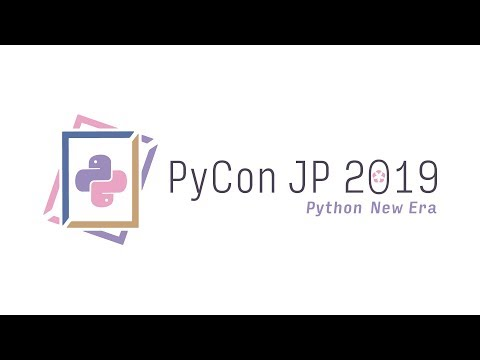

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("6JuB1GiDLQQ", start=512)

## Installation

GetFEM including its python interface can be installed from a terminal by executing aptitude update and aptitude install python3-getfem++.

The additional packages in [requirements.txt](https://github.com/getfem-doc/getfem-binder/blob/master/requirements.txt) are required for this tutorial. You do not need to build these environments because they are already configured in the [Dockerfile](https://github.com/getfem-doc/getfem-binder/blob/master/Dockerfile).

## The problem setting

The problem refers to ["Poisson's Equation on Unit Disk"](https://mathworks.com/help/pde/ug/solve-poissons-equation-on-a-unit-disk.html) published by Math Works's homepage.


$$−\Delta u=1 \ {\rm on}\  \Omega, u=0 \ {\rm on}\  \delta \Omega $$

![pdedemo1_01](https://jp.mathworks.com/help/examples/pde/win64/pdedemo1_01.png)



## How to use GetEM

We take the following steps when using GetFEM to solve finite element problems. See [this page](http://getfem.org/tutorial/basic_usage.html) for more information on using GetFEM.

- define a [MesherObject](http://getfem.org/python/cmdref_MesherObject.html)
- define a [Mesh](http://getfem.org/python/cmdref_Mesh.html)
- define a [MeshFem](http://getfem.org/python/cmdref_MeshFem.html)
- define a [MeshIm](http://getfem.org/python/cmdref_MeshIm.html)
- define a [Model](http://getfem.org/python/cmdref_Model.html) and set it up
- solve Model object
- get value from Model object

## Initialization

GetFEM can be imported following (numpy has also to be imported). 

In [2]:
import getfem as gf
import numpy as np

## Mesh generation

We use GetFEM's [MesherObject](http://getfem.org/python/cmdref_MesherObject.html#) to create a mesh from the geometric information to be analyzed.
This object represents a geometric object to be meshed by the experimental meshing procedure of GetFEM. We can represents a ball of corresponding center and radius by using "ball".

In [3]:
center = [0.0, 0.0]
radius = 1.0

mo = gf.MesherObject("ball", center, radius)

We can make mesh object `mesh` by calling the experimental mesher of GetFEM on the geometry represented by `mo`.

In [4]:
h = 0.1
mesh = gf.Mesh("generate", mo, h, 2)

## Boundary selection

To define a boundary condition, we set a boundary number on the outer circumference of the circle.

In [5]:
outer_faces = mesh.outer_faces()
OUTER_BOUND = 1
mesh.set_region(OUTER_BOUND, outer_faces)

## Mesh draw

We visualize the created mesh to check its quality. We make Slice object to create a mesh slice. We can output mesh objects, but matplotlib can only output triangles. Therefore, we convert mesh to triangles on the slice object.

In [6]:
sl = gf.Slice(("none",), mesh, 1)

We can export a slice to VTK file by using export_to_vtk method.

In [7]:
sl.export_to_vtk("sl.vtk", "ascii")

We can rendere VTK files using Paraview or mayavi2. In order to display in the jupyter notebook this time, we read in meshio and draw in matplotlib.

In [8]:
import meshio

reader = meshio.read("sl.vtk")
points = reader.points
cells = reader.cells[0][1]

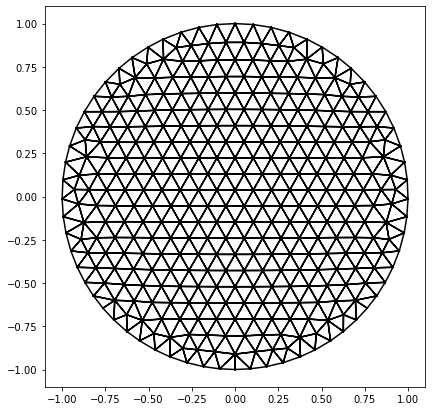

In [9]:
%matplotlib inline
from matplotlib.pyplot import figure

figure = figure(figsize=(7, 7))
axes = figure.add_subplot(aspect="equal")
axes.triplot(points[:, 0], points[:, 1], cells, color="black")

## Definition of finite element methods and integration method

We define the finite element and integration methods to use. We define a MeshFem that defines the degree of freedom of the mesh in the first order.

In [10]:
mfu = gf.MeshFem(mesh, 1)

Next we set the finite element used. `classical_finite_element` means a continuous Lagrange element and remember that elements_degree has been set to 2 which means that we will use quadratic (isoparametric) elements.

In [11]:
elements_degree = 2
mfu.set_classical_fem(elements_degree)

The last thing to define is an integration method mim. There is no default integration method in GetFEM so this is mandatory to define an integration method. Of course, the order of the integration method have to be chosen sufficient to make a convenient integration of the selected finite element method. Here, the square of `elements_degree` is sufficient.

In [12]:
mim = gf.MeshIm(mesh, pow(elements_degree, 2))

## Model definition
The model object in GetFEM gather the variables of the models (the unknowns), the data and what is called the model bricks. The model bricks are some parts of the model (linear or nonlinear terms) applied on a single variable or linking several variables. They are used to make the assembly of the (tangent) linear system (see The model object for more details).
$$ [K] \left\{ u \right\} = \left\{ F \right\} $$

In [13]:
md = gf.Model("real")
md.add_fem_variable("u", mfu)

## Poisson's equation
To define poisson's equation, we have to deifine Laplacian term and RHS source term. We can add Laplacian term (which called brick in GetFEM) by using `add_Laplacian_brick`.

In [14]:
md.add_Laplacian_brick(mim, "u")

0

If you want to define constants in GetFEM, we use `add_fem_data` method.

In [15]:
F = 1.0
md.add_fem_data("F", mfu)

We can set constant values with the `set_variable` method.

In [16]:
md.set_variable("F", np.repeat(F, mfu.nbdof()))

We define the term RHS using the constant F defined. We use the `add_source_term_brick` method for the definition.

In [17]:
md.add_source_term_brick(mim, "u", "F")

1

Finally, we set the Dirichlet condition at the boundary.

In [18]:
md.add_Dirichlet_condition_with_multipliers(mim, "u", elements_degree - 1, OUTER_BOUND)

2

## Model solve
Once the model is correctly defined, we can simply solve it by:

In [19]:
md.solve()

(0, 1)

## Export/visualization of the solution

The finite element problem is now solved. We can get the solution $u$ by using `variable` method.

In [20]:
U = md.variable("u")

We can output the computed u with the mesh of the Slice object.

In [21]:
sl.export_to_vtk("u.vtk", "ascii", mfu, U, "U")
reader = meshio.read("u.vtk")
points = reader.points
cells = reader.cells[0][1]
point_data = reader.point_data["U"]

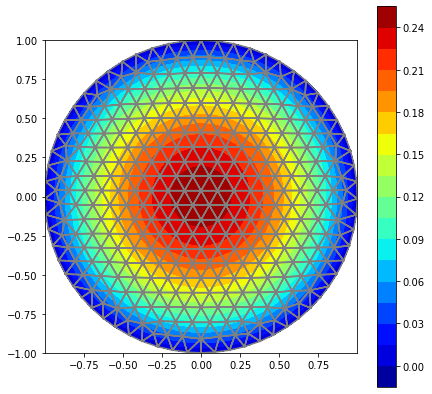

In [22]:
from matplotlib.pyplot import figure

figure = figure(figsize=(7, 7))
axes = figure.add_subplot(aspect="equal")
axes.triplot(points[:, 0], points[:, 1], cells, color="gray")
contour = axes.tricontourf(
    points[:, 0], points[:, 1], cells, point_data, 16, cmap="jet"
)
figure.colorbar(contour)

## Exact solution

The exact solution to this problem is given by the following equation:
$$u(x, y) = \dfrac{1-x^2-y^2}{4}$$

In [23]:
evalue = mfu.eval("(1-x*x-y*y)/4")

We can calculate the error for the L2 and H1 norms by using `compute`:

In [24]:
L2error = gf.compute(mfu, U - evalue, "L2 norm", mim)
H1error = gf.compute(mfu, U - evalue, "H1 norm", mim)
print("Error in L2 norm : ", L2error)
print("Error in H1 norm : ", H1error)

Error in L2 norm :  1.965329030617887e-06
Error in H1 norm :  0.00010936971229962165


As you can see, the size of the error is within the acceptable range.